<a href="https://colab.research.google.com/github/Qiaochu-Zhang/C-_Grades_with_Hash_Table/blob/main/resnetresnet18_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install torch torchvision
!pip install opencv-python


Using device: cuda
Total dataset size: 743
Training+Validation set size: 668
Test set size: 75


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]



Fold 1
--------------------------------
Epoch [1/5], Loss: 0.4735
Validation Accuracy: 69.40%
Epoch [2/5], Loss: 0.1974
Validation Accuracy: 79.10%
Epoch [3/5], Loss: 0.0699
Validation Accuracy: 87.31%
Epoch [4/5], Loss: 0.0310
Validation Accuracy: 85.07%
Epoch [5/5], Loss: 0.0183
Validation Accuracy: 88.06%


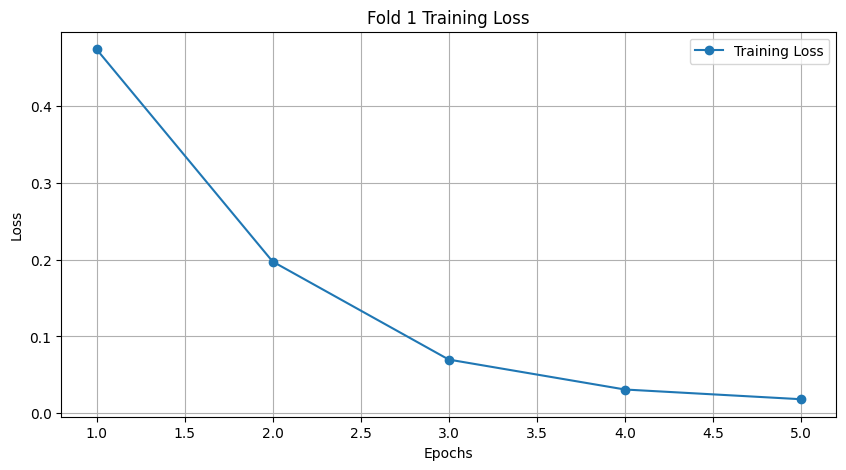

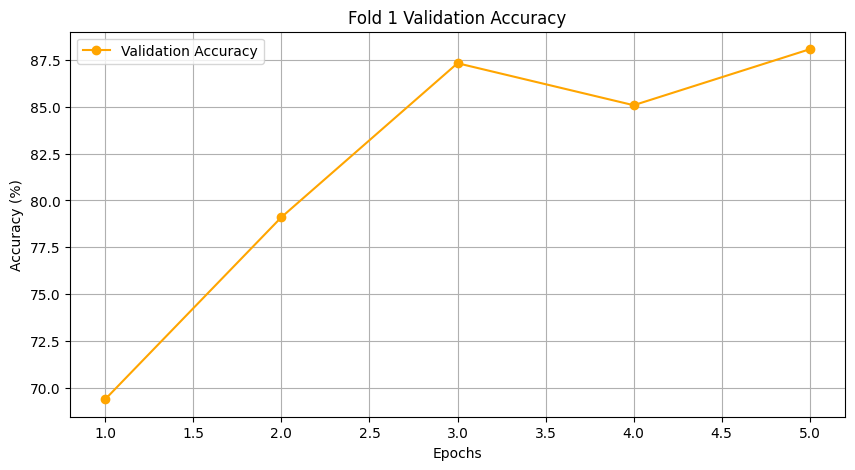

Best Validation Accuracy for Fold 1: 88.06%

Fold 2
--------------------------------
Epoch [1/5], Loss: 0.4924
Validation Accuracy: 73.88%
Epoch [2/5], Loss: 0.1725
Validation Accuracy: 86.57%
Epoch [3/5], Loss: 0.0728
Validation Accuracy: 86.57%
Epoch [4/5], Loss: 0.0685
Validation Accuracy: 88.06%
Epoch [5/5], Loss: 0.0206
Validation Accuracy: 88.06%


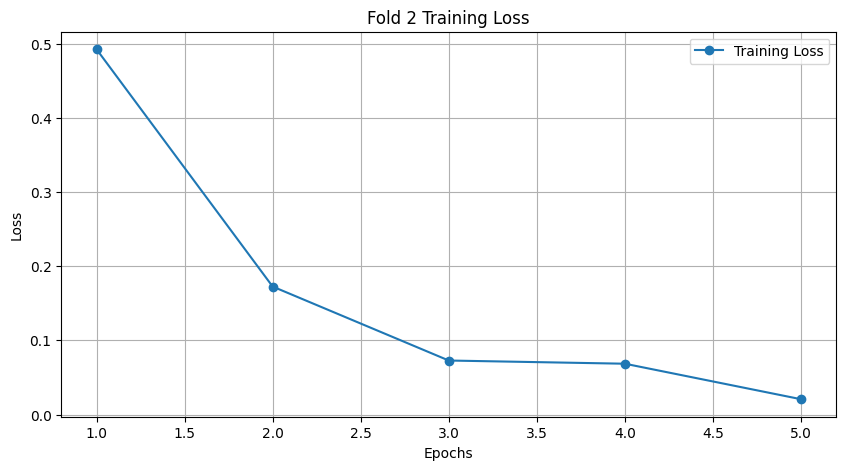

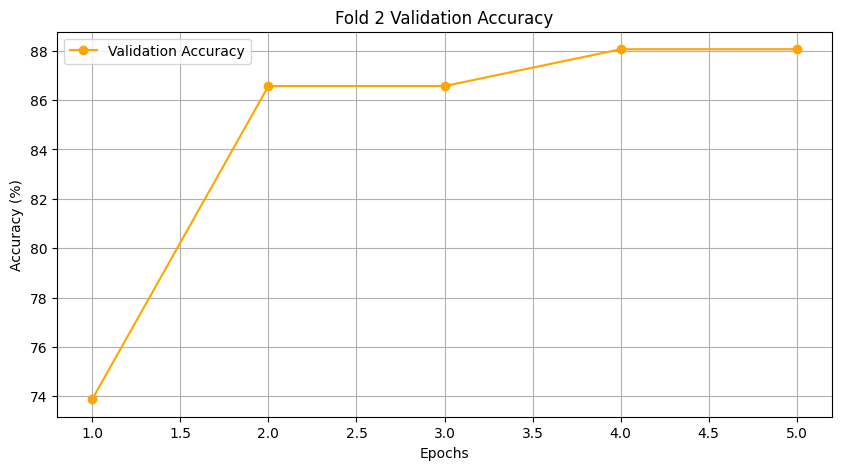

Best Validation Accuracy for Fold 2: 88.06%

Fold 3
--------------------------------
Epoch [1/5], Loss: 0.4688
Validation Accuracy: 75.37%
Epoch [2/5], Loss: 0.1333
Validation Accuracy: 92.54%
Epoch [3/5], Loss: 0.1703
Validation Accuracy: 91.04%
Epoch [4/5], Loss: 0.1038
Validation Accuracy: 89.55%
Epoch [5/5], Loss: 0.0543
Validation Accuracy: 89.55%


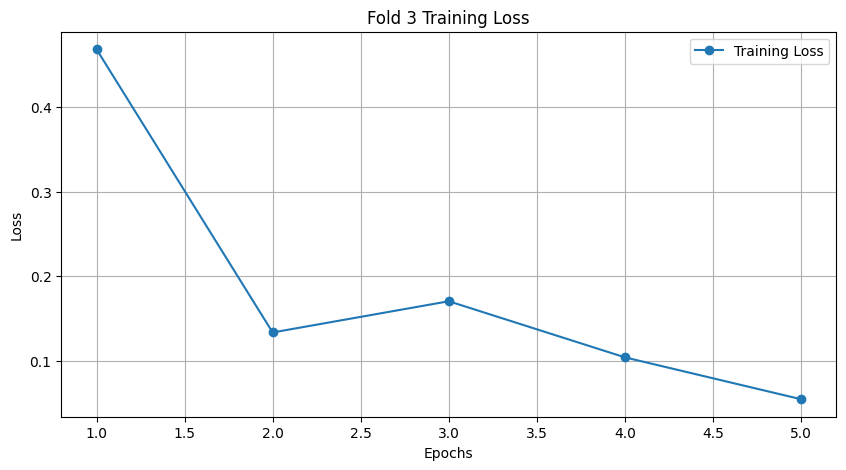

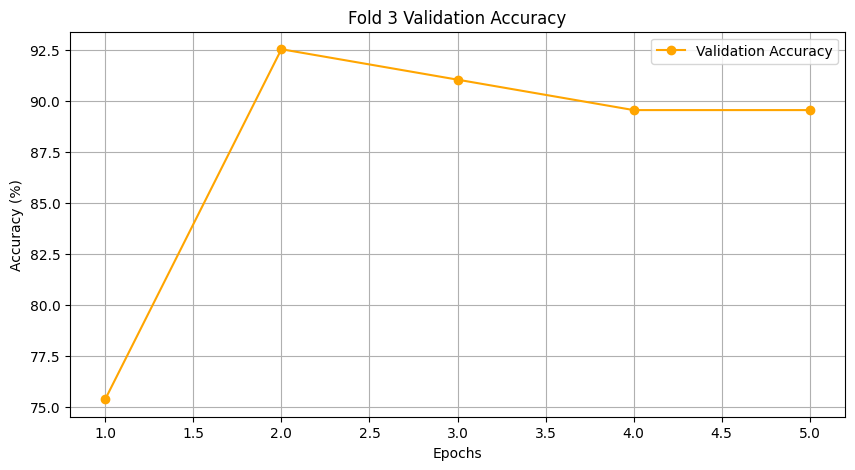

Best Validation Accuracy for Fold 3: 92.54%

Fold 4
--------------------------------
Epoch [1/5], Loss: 0.4874
Validation Accuracy: 69.92%
Epoch [2/5], Loss: 0.1387
Validation Accuracy: 85.71%
Epoch [3/5], Loss: 0.0824
Validation Accuracy: 87.22%
Epoch [4/5], Loss: 0.0717
Validation Accuracy: 87.22%
Epoch [5/5], Loss: 0.0902
Validation Accuracy: 87.22%


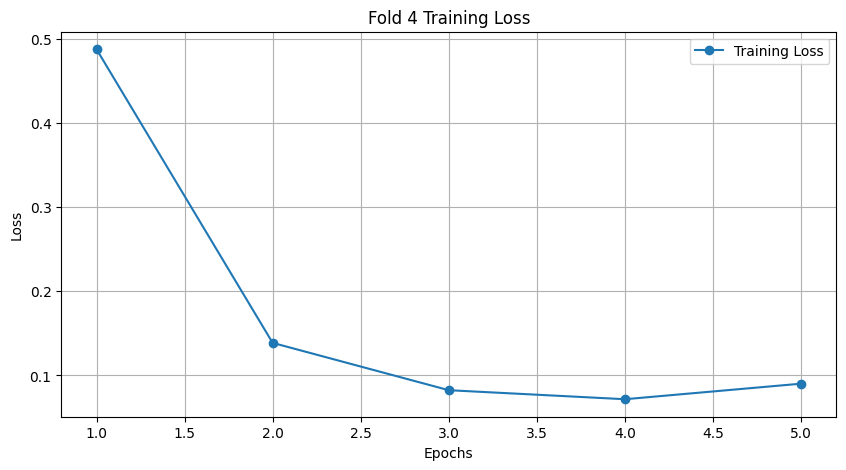

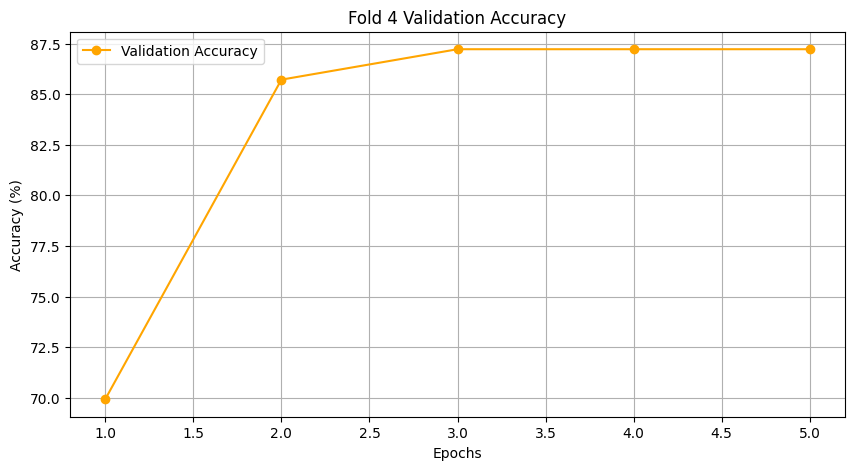

Best Validation Accuracy for Fold 4: 87.22%

Fold 5
--------------------------------
Epoch [1/5], Loss: 0.5110
Validation Accuracy: 78.95%
Epoch [2/5], Loss: 0.1877
Validation Accuracy: 75.94%
Epoch [3/5], Loss: 0.0738
Validation Accuracy: 90.23%
Epoch [4/5], Loss: 0.1002
Validation Accuracy: 89.47%
Epoch [5/5], Loss: 0.0615
Validation Accuracy: 90.98%


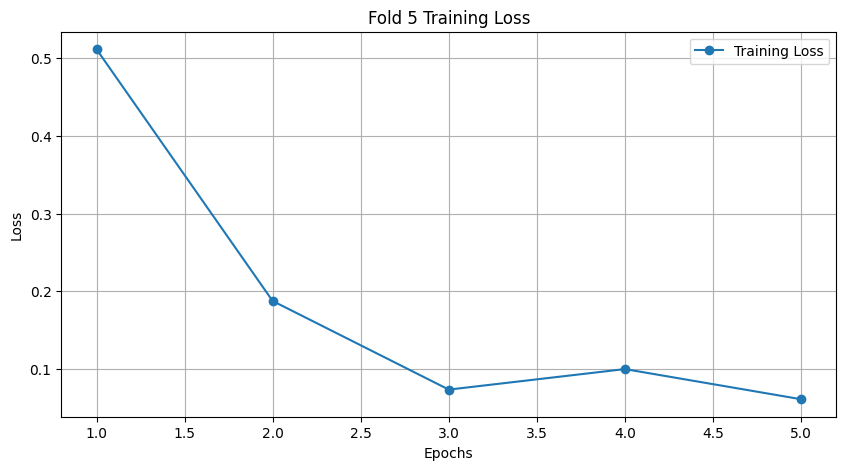

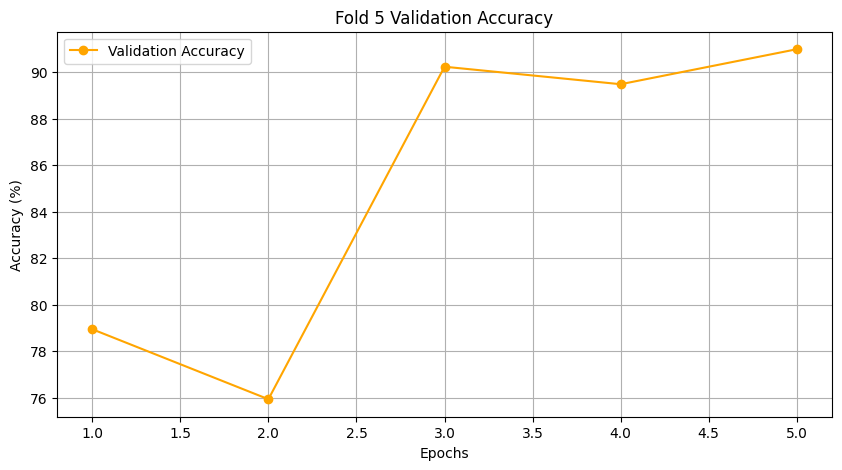

Best Validation Accuracy for Fold 5: 90.98%

Test Accuracy: 89.33%


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import cv2
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import KFold, train_test_split
import random
import matplotlib.pyplot as plt
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


# 自定义数据集类，提取噪声作为输入
class NoiseDataset(Dataset):
    def __init__(self, image_folder, label):
        self.image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
        self.labels = [label] * len(self.image_paths)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # 修改为224x224
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])  # 单通道归一化
        ])

    def extract_noise(self, image_path):
        """提取图片的噪声特征"""
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            # 如果无法读取图像，返回None
            return None
        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        noise = cv2.absdiff(img, blurred)  # 计算噪声图
        return Image.fromarray(noise)  # 转换为 PIL 格式

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 提取噪声图像
        noise_image = self.extract_noise(self.image_paths[idx])
        if noise_image is None:
            # 如果无法读取图像，则跳过该样本
            return self.__getitem__((idx + 1) % len(self.image_paths))
        img_tensor = self.transform(noise_image)
        label = self.labels[idx]
        return img_tensor, label


# 定义数据集路径
real_images_path = '/content/drive/MyDrive/Real'  # 请根据您的实际路径调整
ai_images_path = '/content/drive/MyDrive/fake'    # 请根据您的实际路径调整

# 加载真实图片和AI生成的图片数据集
real_dataset = NoiseDataset(real_images_path, label=0)
ai_dataset = NoiseDataset(ai_images_path, label=1)

# 合并数据集
full_dataset = real_dataset + ai_dataset

# 获取所有样本的标签
labels = [label for _, label in full_dataset]

# 划分测试集（约10%）
test_size = 0.1
train_val_indices, test_indices = train_test_split(
    range(len(full_dataset)),
    test_size=test_size,
    stratify=labels,
    random_state=42
)

# 创建训练+验证集和测试集
train_val_dataset = Subset(full_dataset, train_val_indices)
test_dataset = Subset(full_dataset, test_indices)

print(f"Total dataset size: {len(full_dataset)}")
print(f"Training+Validation set size: {len(train_val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# 加载预训练的ResNet18模型
model = models.resnet18(pretrained=True)

# 修改第一层卷积层，适应单通道输入
original_conv1 = model.conv1
model.conv1 = nn.Conv2d(
    in_channels=1,
    out_channels=original_conv1.out_channels,
    kernel_size=original_conv1.kernel_size,
    stride=original_conv1.stride,
    padding=original_conv1.padding,
    bias=original_conv1.bias is not None
)
with torch.no_grad():
    model.conv1.weight = nn.Parameter(original_conv1.weight.sum(dim=1, keepdim=True))

# 修改最后的全连接层，适应2个类别
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# 将模型移动到设备上
model = model.to(device)

# 定义K折交叉验证
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 用于保存最佳模型的参数
best_model_wts = None
best_acc = 0.0

# 在训练+验证集上进行K折交叉验证
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_val_indices)):
    print(f'\nFold {fold + 1}')
    print('--------------------------------')

    # 在fold开始时，初始化列表用于保存训练损失和验证准确率
    train_losses = []
    val_accuracies = []

    # 获取当前折的训练和验证索引
    train_sub_ids = [train_val_indices[i] for i in train_ids]
    val_sub_ids = [train_val_indices[i] for i in val_ids]

    # 定义训练和验证数据集
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_sub_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_sub_ids)

    # 定义数据加载器
    train_loader = torch.utils.data.DataLoader(
        full_dataset,
        batch_size=16, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(
        full_dataset,
        batch_size=16, sampler=val_subsampler)

    # 重新初始化模型和优化器
    model = models.resnet18(pretrained=True)

    # 修改第一层卷积层，适应单通道输入
    original_conv1 = model.conv1
    model.conv1 = nn.Conv2d(
        in_channels=1,
        out_channels=original_conv1.out_channels,
        kernel_size=original_conv1.kernel_size,
        stride=original_conv1.stride,
        padding=original_conv1.padding,
        bias=original_conv1.bias is not None
    )
    with torch.no_grad():
        model.conv1.weight = nn.Parameter(original_conv1.weight.sum(dim=1, keepdim=True))

    # 修改最后的全连接层，适应2个类别
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    # 将模型移动到设备上
    model = model.to(device)

    # 定义优化器
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    num_epochs = 5  # 可以根据需要调整

    # 开始训练
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

        # 记录训练损失
        train_losses.append(avg_loss)

        # 在验证集上评估模型
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(device)
                target = target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

        # 记录验证准确率
        val_accuracies.append(accuracy)

    # 绘制训练损失曲线
    plt.figure(figsize=(10, 5))
    plt.title(f'Fold {fold + 1} Training Loss')
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 绘制验证准确率曲线
    plt.figure(figsize=(10, 5))
    plt.title(f'Fold {fold + 1} Validation Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 保存结果
    fold_best_acc = max(val_accuracies)
    print(f'Best Validation Accuracy for Fold {fold + 1}: {fold_best_acc:.2f}%')

    # 如果当前折的最佳准确率高于全局最佳准确率，保存模型参数
    if fold_best_acc > best_acc:
        best_acc = fold_best_acc
        best_model_wts = model.state_dict()

# 加载最佳模型参数
model.load_state_dict(best_model_wts)

# 在测试集上评估模型
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
test_accuracy = 100 * correct / total
print(f'\nTest Accuracy: {test_accuracy:.2f}%')
